<a href="https://colab.research.google.com/github/OluwatodimuAdegoke/ComputerVisionCourse/blob/main/Car_Price_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [21]:
import tensorflow as tf # Models
import pandas as pd  # Reading and processing data
import seaborn as sns # Visualization
from tensorflow.keras.layers import Normalization, Dense, InputLayer
from tensorflow.keras.losses import MeanSquaredError, Huber, MeanAbsoluteError

Data Preparation

In [4]:
# Read the data
data = pd.read_csv("train.csv",sep=',')
data.shape
# Plots the graphs of each variable against the other
# sns.pairplot(data[['years','km','rating','condition','economy','top speed','hp', 'torque','current price']])

(1000, 12)

In [5]:
tensor_data = tf.constant(data)
# Cast to float32
tensor_data = tf.cast(tensor_data,tf.float32)
# Shuffle the data to avoid bias
tensor_data = tf.random.shuffle(tensor_data)


In [6]:
x = tensor_data[:,3:-1]
print(x.shape)
y = tensor_data[:,-1]
y = tf.expand_dims(y, axis = -1)
print(y.shape)

(1000, 8)
(1000, 1)


In [7]:
# Normalize the input
normalizer = Normalization()
# Gets the mean and std itself
normalizer.adapt(x)
normalizer(x)

<tf.Tensor: shape=(1000, 8), dtype=float32, numpy=
array([[ 1.4194919 , -1.3704551 ,  0.00855871, ...,  0.83548087,
         0.46102104, -0.21013637],
       [-0.32650152,  1.3298233 ,  0.00855871, ..., -1.6543096 ,
        -1.5870923 ,  0.12243389],
       [ 1.4194919 ,  0.8236434 , -0.7046624 , ..., -1.0837327 ,
        -0.758094  ,  0.7400644 ],
       ...,
       [-1.4904971 , -0.3616304 , -1.4178835 , ...,  1.0429634 ,
        -0.1729188 ,  0.5025142 ],
       [ 0.2554963 , -1.623442  , -1.4178835 , ...,  0.9392221 ,
        -0.1241542 , -1.3978873 ],
       [ 0.8374941 ,  0.5990063 ,  0.7217798 , ...,  1.7172817 ,
         1.5338423 , -1.3978873 ]], dtype=float32)>

In [18]:
# Create a model with keras
model = tf.keras.Sequential([
    InputLayer(input_shape=(8,)),
    normalizer,
    Dense(1)])

model.summary()


Model: "sequential_4"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  multiple                  17        
 on)                                                             
                                                                 
 dense_4 (Dense)             (None, 1)                 9         
                                                                 
Total params: 26 (108.00 Byte)
Trainable params: 9 (36.00 Byte)
Non-trainable params: 17 (72.00 Byte)
_________________________________________________________________


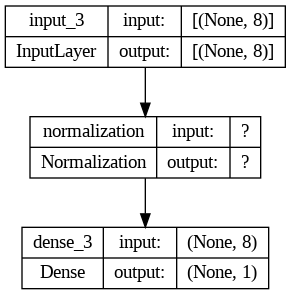

In [17]:
tf.keras.utils.plot_model(model,to_file="model.png",show_shapes=True)

In [24]:
# Uses the mean square error. Can also use the mean absolute error
# Use mean absolute error when there is a outlier that'll affect the data
# Can also use Huber loss
model.compile(loss=MeanAbsoluteError())